# Fitting is an Art!

Python macro for testing which fitting procedure is likely to give the "best" results.

In this case, we consider **Gaussian distributions on constant background (peak fitting and searching)**, where the fit precision and hypothesis testing can be improved by sharing common parameters.

### Authors:
- Troels Petersen ([email](mailto:petersen@nbi.dk))

### Last update:
- 28th of December 2024

In [124]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit, cost
from scipy import stats

In [125]:
r = np.random
r.seed(42)
SavePlots = False

## CASE: Gaussian distributions on a constant background:

The initial fitting function is the following:

* $f_{1}(x) = {Gauss + Constant} =  \frac{N_{sig}}{\sigma\sqrt(2\pi)}\cdot \exp \left[-0.5 \cdot\left(\frac{(x-\mu)}{\sigma}\right)^{2} \right] + C~~~$ for $x$ in $[-\infty,\infty]$

It disregards that there are additional signal peaks at higher values. Your job is to expand the fit until it really describes the data.

In [126]:
# Signal parameters:
Npoints_gauss = 2000
fN     = 0.5
mux    = 1.43
dmux   = 1.41
sigmax = 0.15          

# Background parameters:
Npoints_pol0 = 5000

# Binning parameters:
xmin   =  0.0
xmax   = 10.0
Nbins  =  200
binwidth_gauss = (xmax-xmin) / float(Nbins)
print(f"  The bin width is: {binwidth_gauss:5.2f}")

  The bin width is:  0.05


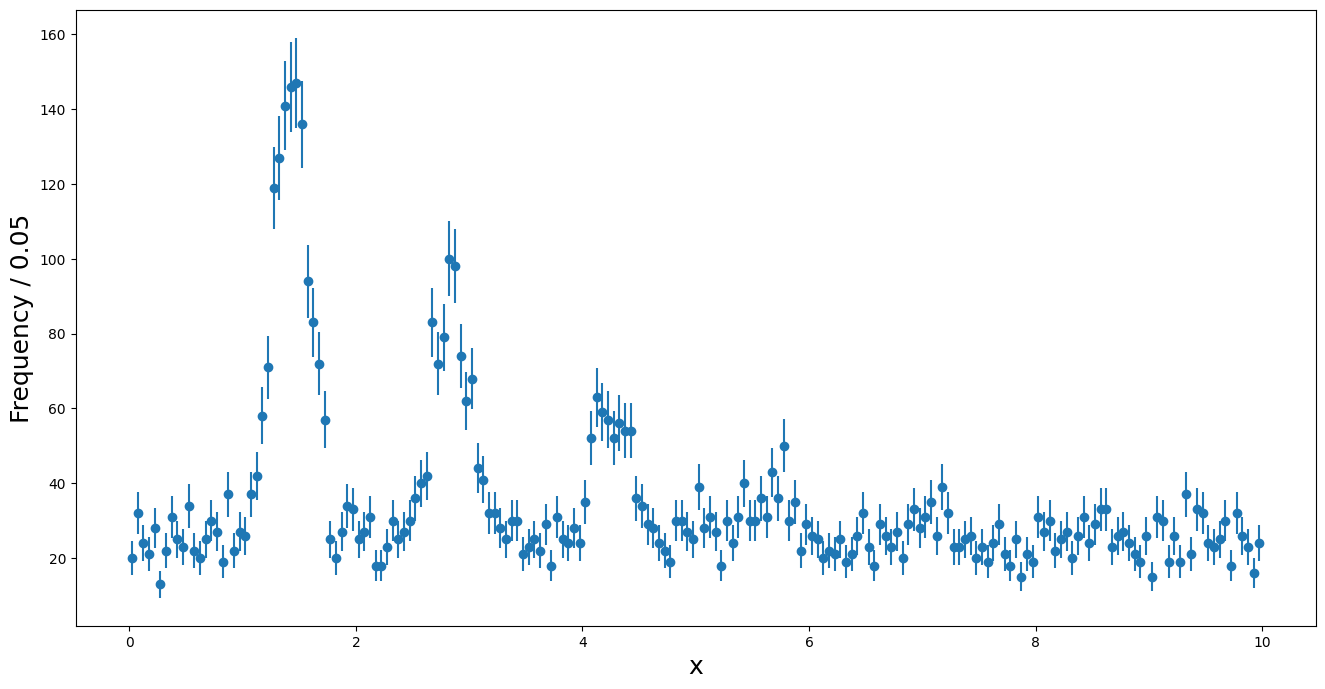

In [127]:
# Fill histogram with signal and background events:
Npeak = np.random.geometric(fN, Npoints_gauss)                  # Make random assignment to Gaussian peaks
sig = np.random.normal(loc=mux+dmux*(Npeak-1), scale=sigmax)    # Now generate signal according to these peaks
bkg = np.random.uniform(xmin, xmax, size=Npoints_pol0)

data = np.concatenate([sig, bkg])
counts, bin_edges = np.histogram(data, bins=Nbins, range=(xmin, xmax))
unc_count = np.sqrt(counts)
x = bin_edges[:-1]+(bin_edges[1]-bin_edges[0])/2.

fig, ax = plt.subplots(figsize=(16, 8))
ax.errorbar(x, counts, yerr=unc_count, marker = 'o', ls='')
ax.set_xlabel('x', fontsize=18)
ax.set_ylabel('Frequency / 0.05', fontsize=18);

### Define function (including bin width to get normalisation right):


In [128]:
def func_gpol0(x, N,N2,N3, N4 ,mu1,mu2,mu3,mu4, sigma, cst):
    # norm = binwidth_gauss * N / np.sqrt(2.0*np.pi) / sigma
    norm = binwidth_gauss/ np.sqrt(2.0*np.pi) / sigma
    # norm2 = binwidth_gauss*N / np.sqrt(2.0*np.pi) / sigma2
    # norm3 = binwidth_gauss*N / np.sqrt(2.0*np.pi) / sigma3
    # norm4 = binwidth_gauss*N / np.sqrt(2.0*np.pi) / sigma4
    z1 = (x-mu1)/sigma
    z2 = (x-mu2)/sigma
    z3 = (x-mu3)/sigma
    z4 = (x-mu4)/sigma
    # z3 = (x-mu3)/sigma3
    # z4 = (x-mu4)/sigma4
    return norm*(N*np.exp(-0.5*z1**2) + N2*np.exp(-0.5*z2**2) + N3*np.exp(-0.5*z3**2) + N4*np.exp(-0.5*z4**2)) + cst
    # return norm * np.exp(-0.5*z**2) + cst

In [ ]:
mask = counts>0
cfit = cost.LeastSquares(x[mask], counts[mask], unc_count[mask], func_gpol0)
mfit = Minuit(cfit, N=160, N2=100, N3 = 60,N4=50, mu1=1, mu2=3, mu3 = 4.1, mu4 =5.8, sigma=1.0, cst=20.0)
mfit.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 201.7 (χ²/ndof = 1.1)      │              Nfcn = 489              │
│ EDM = 6.27e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N     │    990    │    40     │            │            │         │         │       │
│ 1 │ N2    │    531    │    30     │            │            │         │         │       │
│ 2 │ N3    │    293    │    25     │            │            │         │         │       │
│ 3 │ N4    │    114    │    21     │            │            │         │         │       │
│ 4 │ mu1   │   1.427   │   0.007   │            │            │         │         │       │
│ 5 │ mu2   │   2.840   │   0.011   │            │            │         │         │       │
│ 6 │ mu3   │   4.256   │   0.017   │            │            │         │         │       │
│ 7 │ mu4   │   5.68    │   0.04    │            │            │         │         │       │
│ 8 │ sigma │   0.157   │   0.005   │            │            │         │         │       │
│ 9 │ cst   │   24.2    │    0.4    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────────────────────────────────────────────────────────────────┐
│       │         N        N2        N3        N4       mu1       mu2       mu3       mu4     sigma       cst │
├───────┼─────────────────────────────────────────────────────────────────────────────────────────────────────┤
│     N │  1.45e+03     0.1e3     0.1e3     0.1e3   0.19e-3   3.83e-3   7.32e-3   -0.0228 44.483e-3     -3.41 │
│    N2 │     0.1e3       924     0.1e3         0  -0.34e-3   0.96e-3   5.71e-3   -0.0177 35.133e-3     -3.01 │
│    N3 │     0.1e3     0.1e3       643         0  -0.22e-3   2.06e-3  -1.82e-3   -0.0119 24.584e-3     -2.64 │
│    N4 │     0.1e3         0         0       428  -0.11e-3   1.20e-3   2.20e-3    0.0141 14.942e-3     -2.28 │
│   mu1 │   0.19e-3  -0.34e-3  -0.22e-3  -0.11e-3  4.41e-05        -0        -0         0        -0         0 │
│   mu2 │   3.83e-3   0.96e-3   2.06e-3   1.20e-3        -0  0.000114         0        -0  0.002e-3  -0.04e-3 │
│   mu3 │   7.32e-3   5.71e-3  -1.82e-3   2.20e-3        -0         0  0.000285        -0  0.004e-3  -0.07e-3 │
│   mu4 │   -0.0228   -0.0177   -0.0119    0.0141         0        -0        -0   0.00149 -0.013e-3    0.0002 │
│ sigma │ 44.483e-3 35.133e-3 24.584e-3 14.942e-3        -0  0.002e-3  0.004e-3 -0.013e-3   2.3e-05 -0.596e-3 │
│   cst │     -3.41     -3.01     -2.64     -2.28         0  -0.04e-3  -0.07e-3    0.0002 -0.596e-3     0.178 │
└───────┴─────────────────────────────────────────────────────────────────────────────────────────────────────┘

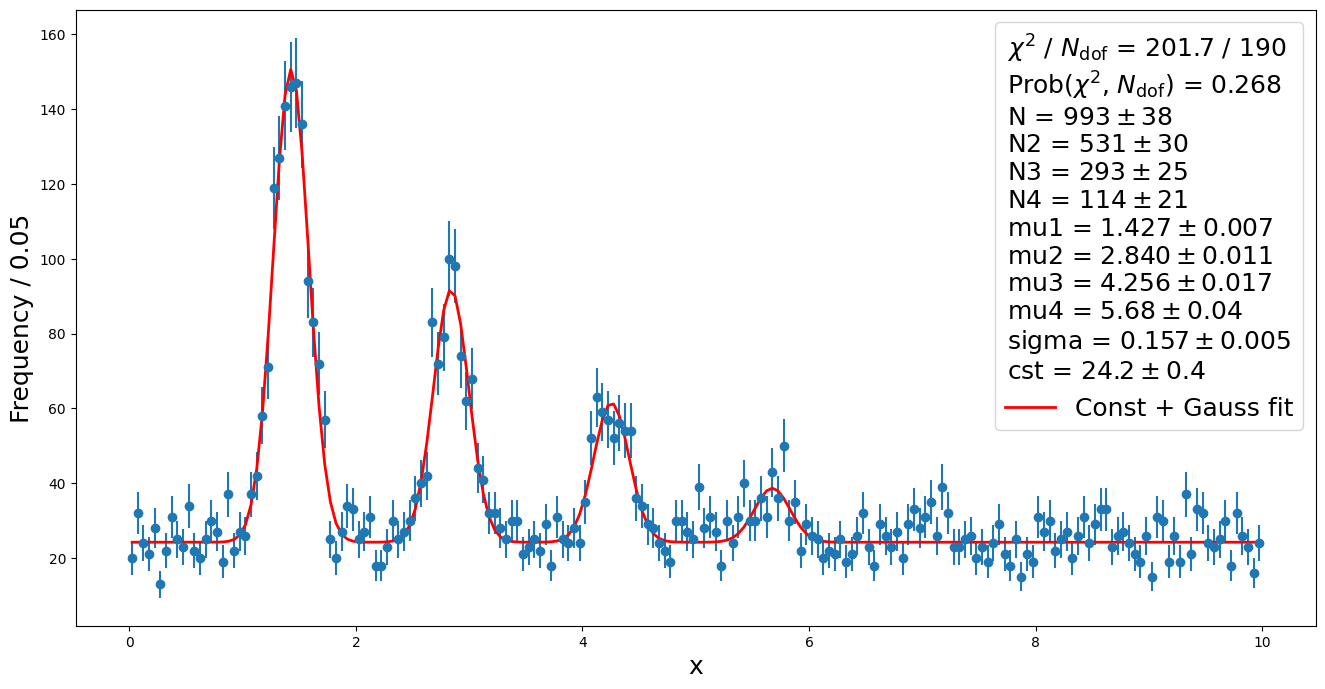

In [130]:
if (not mfit.fmin.is_valid) :                                   # Check if the fit converged
    print("  WARNING: The ChiSquare fit DID NOT converge!!!")

ax.plot(x, func_gpol0(x, *mfit.values[:]), 'r', linewidth=2.0, label='Const + Gauss fit')

# Adding fit results to plot:
chi2 = mfit.fval                     # ChiSquare value
Ndof = len(x[mask]) - mfit.nfit      # Number of (non-empty) bins
Prob = stats.chi2.sf(chi2, Ndof)     # ChiSquare probability given Ndof

fit_info = [f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {chi2:.1f} / {Ndof}", f"Prob($\\chi^2$, $N_\\mathrm{{dof}}$) = {Prob:.3f}",]
for p, v, e in zip(mfit.parameters, mfit.values[:], mfit.errors[:]) :
    Ndecimals = max(0,-np.int32(np.log10(e)-1-np.log10(2)))                                # Number of significant digits
    fit_info.append(f'{p} = ${v:{10}.{Ndecimals}{"f"}} \\pm {e:{10}.{Ndecimals}{"f"}}$')

ax.legend(title="\n".join(fit_info), fontsize=18, title_fontsize = 18, alignment = 'center');
fig

# Questions:

 1. Look at the data plot and the corresponding fit. What type of fit is it? Does it
    run well (or at all)? And once it runs, does it seem to be reasonable? Why/why not?
    What is the p-value from the minimal Chi2 that your fit obtained, once you got any
    "reasonable" fit to work? Is it acceptable?
    Does the fitting function include all features of the data? Why/why not? Try for
    2-5 minutes and discuss it with others (or just think for yourself), before reading on!

---
_2-5 minutes later_...

---

 2. As it happens, there seem to be a additional peaks. Try to write a new and
    expandeded fitting function, which includes these features in the model, and get the
    fit to run. How significant is the additional peak(s), based on significance of the
    amplitude? And what test would you apply to this, if you wanted to make a full-fledged
    hypothesis test between the two models? Are they nested? Can you actually get a number out?
    Again, discuss it before coding on.

---
_10-20 minutes later_...

---

 3. Imagine that you concluded that there were additional new peaks, and that you were sure that
    they had the same width as the original peak (for example because the width was due to
    the resolution of the apperatus, and not the peak itself). Does that help you in the fit,
    and if so, how? Does the significance of the peaks increase? Would it always do that?
    Also imagine, that the parameter of interest is the distance between the peaks. How
    would you now write your fitting function?

 4. How would you test, if the peaks are really equidistant? Do so...

 5. Assuming the peaks to be equidistant, how would you test, if the peaks are consistent with an unobserved peak at exactly zero? Do so...

 6. If one wanted to test the G+pol0 vs. the N*G+pol0 models against each other, which might be relevant, then considering the difference in ChiSquare values or -2ln of the likelihood ratio would be obvious (these two gives the same result, when errors are Gaussian and the binning does not have any effect). Wilk's theorem would provide the way to produce a p-value, thus doing a proper hypothesis test using the likelihood ratio test:

* Using iminuit, fit the data with both hypothesis, and note the Chi2 or LLH value (using `mfit.fval`).
* Then compute the test statistic $\chi^2_{1} - \chi^2_{2}$ or $-2\log{\frac{LH_{1}}{LH_{2}}}$, and see that it is $\chi^{2}$ distributed (Wilk's Theorem) from repeating many experiments.

NOTE: The test statistic distribution will depend on how many peaks you fit and if you (smartly) eliminated one parameter from the second fit.

# Learning points:

This exercise in "fitting tricks" should teach you that:
1. __Good starting values is paramount!__ (Almost all fits fail with poor starting values).
2. The form of the fitting function is also important.<br>
   a. Ensure that the x-values do not represent some small range far from 0.<br>
   b. Ensure that you give the fitting function enough freedom to fit the data.<br>
   c. Conversely, try to curb the number of parameters, if there are arguments for doing so (calibration peaks).<br>
   d. Make sure that you've normalised your fitting PDFs, to avoid correlations between normalisation and parameters.
3. If a fit continues to fail, try simply to draw the function and starting values on top of the data. Often, they don't match well (general advice, not just in this exercise).